# Imports and Settings

In [1]:
#%matplotlib inline
#%matplotlib notebook
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib import colors, cm, markers
import json
from itertools import zip_longest, product
import os
from math import sqrt
import holidays
import seaborn as sns
import time
import datetime

# instance_varibles
# GLOBAL_VARIABLES

In [2]:
# Pandas display options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)
pd.set_option('display.width', 1000)

In [3]:
np.random.seed(0)

In [4]:
print(os.getcwd())

c:\Workspace\veritas


# Data loading

In [5]:
with open("veritas_data/parser_menus/menu.json", "r") as f:
    MENU = json.load(f)

In [6]:
def get_store_id_to_name(file_name):
    with open(file_name, "r", encoding="utf-8") as f:
        raw_stores = json.load(f)
        id_to_name = {store["Id"] : store["Name"] for store in raw_stores}
    return id_to_name

STORE_ID_TO_NAME = get_store_id_to_name("veritas_data/stores/all.json")

In [7]:
STORE_ID_TO_NAME[120]

'Karlstad, Våxnäs'

In [8]:
# start_date, fiters out all dates before start_date
# date_unit, determines the unit of the date column if date is a number
def load_ts_data(file_name, start_date=None, date_unit=None):
    print("Loading main columns...")
    df = pd.read_csv(file_name, usecols=["device_id", "date", "store_id", "class", "total_price"], header=0)

    #print("Formatting main columns...")
    #df["device_id"], device_map = df["device_id"].factorize()
    #df["store_id"], store_map = df["store_id"].factorize()
    #df["class"], class_map = df["class"].factorize()
    #df = df.astype("uint32")

    print("Loading products...")
    with open(file_name, "r") as f:
        num_columns = len(f.readline().split(","))
    for cols in zip_longest(*(iter(range(5, num_columns)),) * 50):
        cols = [c for c in cols if c is not None]
        temp_df = pd.read_csv(file_name, usecols=list(cols), header=0, dtype="uint8")
        temp_df = temp_df.loc[:, (temp_df != 0).any(axis=0)]   # Remove "zero" columns
        df = pd.concat([df, temp_df], axis=1)

    wl = [col for col in df.columns if col not in ['device_id', 'store_id', 'class', "date"]]
    df = df.drop(df[df[wl].eq(0).all(axis=1)].index)
    if date_unit is None:
        df['date'] = pd.to_datetime(df['date'])
    else:
        df['date'] = pd.to_datetime(df['date'], unit=date_unit)
    if start_date is not None:
            df.drop(df[df["date"] < start_date].index, inplace=True)
    df.set_index(["store_id", "device_id", "date"], inplace=True)
    return df#, device_map, store_map, class_map


In [9]:
TS_FILE = "veritas_data/post_parser_orders/device_time_series_2020_01-01_to_02-19.csv"
TSF = load_ts_data(TS_FILE, start_date="2020-01-01", date_unit=None)

Loading main columns...
Loading products...


In [10]:
TSF.drop("class", axis=1, inplace=True)

In [11]:
TSF.columns

Index(['total_price', 'product_4', 'product_5', 'product_6', 'product_8', 'product_9', 'product_10', 'product_11', 'product_12', 'product_14',
       ...
       'product_392', 'product_393', 'product_394', 'product_395', 'product_396', 'product_397', 'product_398', 'product_400', 'product_401', 'product_402'], dtype='object', length=196)

In [12]:
#COL_WL = [col for col in TSF.columns if col not in ["device_id", "store_id", "class"]]

# Utility functions

In [13]:
def save_df(df, path):
    if not os.path.isfile(path):
        df.to_csv(path)
    else:
        print(path, "already exists!")

In [14]:
# Returns the device_id, number of orders and the data frame of the device with the most orders
def get_top_devices(device_id_list, ts_frame, n):
    top_devices = []
    for device_id in device_id_list:
        df = ts_frame.loc[ts_frame["device_id"] == device_id, ["store_id"]]
        try:
            store_id = df.values[0][0]
        except:
            continue
        num_orders = len(df.index)
        top_devices.append((device_id, num_orders, store_id))
        top_devices = sorted(top_devices, key=lambda d: d[1], reverse=True)[:n]
    return top_devices

# Returns df without rows where col_name equals a value occuring less than threshold times
def trim_low_occurance_values(df, col_name, threshold):
    s = df[col_name].value_counts().ge(threshold)
    return df[df[col_name].isin(s[s].index)]

In [15]:
def get_test_train_split(df, train_delta=pd.Timedelta(4, unit='W'), forecast_delta=pd.Timedelta(1, unit='W'), expanding_window=False, seed=0):
    np.random.seed(seed)
    first_date = df.index.get_level_values("date").min()
    last_date = df.index.get_level_values("date").max()
    start = first_date
    mid = start + train_delta
    end = mid + forecast_delta
    
    intervals = []
    while end < last_date:
        intervals.append((start, mid, end))
        t_delta = forecast_delta*max(min(np.random.normal(0.5, 0.05), 1), 0.4)
        if not expanding_window:
            start += t_delta
        mid += t_delta
        end += t_delta
    
    if not expanding_window:
        start = last_date-train_delta-forecast_delta
    mid = last_date-forecast_delta
    end = last_date
    if start > first_date and mid > first_date:
        intervals.append((start, mid, end))
        
    return intervals

In [16]:
# 
def get_intervals(df, t_delta, seed=0):
    np.random.seed(seed)
    first_date = df.index.min()[2]
    last_date = df.index.max()[2]
    time_step = last_date-t_delta
    intervals = []
    while time_step > first_date:
        start = time_step
        end = time_step+t_delta
        intervals.append((start, end))
        time_step -= (t_delta*max(min(np.random.normal(0.5, 0.05), 1), 0.4))
    intervals.append((first_date, first_date+t_delta))
    return intervals

def sparsity_coefficient(df):
    return 1.0 - (np.count_nonzero(df) / np.product(df.shape))

In [17]:
from scipy.spatial.distance import squareform, pdist

def reindex_by_date(df, start, end, freq, fill_value=0):
    dates = pd.date_range(start=start, end=end, freq=freq)
    index = list(set(df.index.droplevel("date").tolist()))
    index.sort()
    dates = [(i, j, d) for i, j in index for d in dates]
    df = df.reindex(dates).fillna(0)
    return df

def flatten_ts(df):
    return df.values.flatten()

# 
def format_ts(df, start, end, freq, whitelist=[], flatten=False, normalize=False, sales_percentage=False):
    product_cols = [col for col in df.columns if "product" in col]
    df.rename(columns={"total_price": "average_price"}, inplace=True)
    df["num_orders"] = 1
    agg_dict = {col_name: np.sum for col_name in df.columns}
    agg_dict.update({"average_price": np.mean})
    df = df.groupby([df.index.get_level_values(i) for i in [0,1]]+[pd.Grouper(freq=freq, level=-1)]).agg(agg_dict)
    df = reindex_by_date(df, df.index.get_level_values("date")[0], df.index.get_level_values("date")[-1], freq)
    if sales_percentage:
        df[product_cols] = df[product_cols].div(df[product_cols].sum(axis=1), axis=0)
    if normalize:
        df -= df.min()
        df /= df.max()
    df = df.fillna(0)
    if flatten:
        df.index.droplevel("store_id")
        device_index = df.index.droplevel("date").drop_duplicates()
        df = df.groupby(level="device_id").apply(flatten_ts)
        df = pd.DataFrame(np.stack(df), index=device_index)
    return df

def correlation_matrix(df, start, end, freq, whitelist, dist_func, normalize=False, sales_percentage=False):
    start_time = time.time()
    ids = df.index.get_level_values("device_id").unique()
    err_df = pd.DataFrame(index=ids, columns=ids)

    print("Formatting devices...")
    df = format_ts(df, start, end, freq, whitelist, normalize=normalize, sales_percentage=sales_percentage, flatten=True)

    print("Generating correlation matrix...")
    err_df = pd.DataFrame(squareform(pdist(df, metric="euclidean")), columns=df.index, index=df.index)
    print("Done!", "\tElapsed time:", str(datetime.timedelta(seconds=(time.time()-start_time))))
    return err_df

# Cluster Score Testing

In [18]:
# Cophenetic Testing

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet

def cophenet_test(df, intervals, freqs, metrics, methods, pcas, whitelist=[], verbose=False):
    start_time = time.time()
    scores = []
    if verbose:
        print("Running tests...")
    windows = [(l, w) for l in intervals for w in get_intervals(df, l)]
    n_tests = len(windows)*len(freqs)*len(metrics)*len(methods)*len(pcas)
    if n_tests == 0:
        print("Parameters generated zero tests!!!")
        return
    tests_completed = 0

    for interval, (start, end) in windows:
        window = df[(df.index.get_level_values("date") > start) & (df.index.get_level_values("date") <= end)]
        n_devices = window.index.get_level_values("device_id").nunique()
        if n_devices > 1:
            for freq in freqs:
                formatted_window = format_ts(window, start, end, freq, whitelist, flatten=True, normalize=True)
                for n_pca in pcas:
                    try:
                        window_components = TruncatedSVD(n_components=n_pca).fit_transform(formatted_window)
                        for metric in metrics:
                            dist = pdist(window_components, metric=metric)
                            for method in methods:
                                if method != "ward" or metric == "euclidean":
                                    link = linkage(dist, method=method)
                                    score = cophenet(link, dist)[0]
                                    scores.append((interval, freq, metric, method, n_pca, score))
                                tests_completed += 1
                                if verbose:
                                    time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                                    print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")
                    except ValueError:
                        break
        else:
            tests_completed += n_tests//len(windows)
            if verbose:
                time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")
                            
        
    if verbose:
        print("\nDone! Total time:", str(datetime.timedelta(seconds=(time.time()-start_time))))
    return scores

In [19]:
from sklearn.cluster import KMeans, OPTICS, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform, pdist

def k_means(x, n_clust):
    return KMeans(n_clusters=n_clust, random_state=0, n_jobs=-1, verbose=2).fit(x).labels_

def optics(x, min_samples):
    return OPTICS(min_samples=min_samples, metric="euclidean").fit(x).labels_

def agglomerative_complete(x, n_clust):
    dist = pdist(x, metric="euclidean")
    link = linkage(dist, method="complete")
    return fcluster(link, t=n_clust, criterion="maxclust").astype("float64")

def agglomerative_single(x, n_clust):
    dist = pdist(x, metric="euclidean")
    link = linkage(dist, method="single")
    return fcluster(link, t=n_clust, criterion="maxclust").astype("float64")

def agglomerative_ward(x, n_clust):
    dist = pdist(x, metric="euclidean")
    link = linkage(dist, method="ward")
    return fcluster(link, t=n_clust, criterion="maxclust").astype("float64")
    
def store_clust(x):
    return x.index.get_level_values("store_id")


In [20]:
# Store based clustering
# 100 PCA!
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def clust_test(df, intervals, freqs, clust_funcs, verbose=False):
    start_time = time.time()
    scores = []
    if verbose:
        print("Running tests...")
    windows = [(l, w) for l in intervals for w in get_intervals(df, l)]
    n_tests = len(windows)*len(freqs)*len(clust_funcs)
    if n_tests == 0:
        print("Parameters generated zero tests!!!")
        return
    tests_completed = 0

    for interval, (start, end) in windows:
        window = df[(df.index.get_level_values("date") > start) & (df.index.get_level_values("date") <= end)]
        n_devices = window.index.get_level_values("device_id").nunique()
        if n_devices > 1:
            for freq in freqs:
                if pd.to_timedelta(freq) > interval:
                    tests_completed += n_tests//len(windows)//len(freqs)
                    if verbose:
                        time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                        print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")   
                    continue
                formatted_window = format_ts(window, start, end, freq, [], flatten=True, normalize=True)    
                svd = TruncatedSVD(n_components=min(1000, formatted_window.shape[1]-1), random_state=0)
                svd.fit(formatted_window)
                variance = svd.explained_variance_ratio_.cumsum()
                window_components = svd.transform(formatted_window)[:,variance < 0.96]
                n_components = window_components.shape[1]
                dist = pdist(window_components, metric="euclidean")
                for clust_func in clust_funcs:
                    si_score = ch_score = np.NINF 
                    db_score = np.inf
                    si_n_clust = ch_n_clust = db_n_clust = None
                    si_n_outliers = ch_n_outliers = db_n_outliers = None
                    if clust_func == optics:
                        for min_samples in range(2, min(100, n_devices//20), 2):
                            clust_labels = clust_func(window_components, min_samples)
                            mask = clust_labels != -1
                            n_outliers = np.count_nonzero(clust_labels == -1)
                            clust_labels = clust_labels[mask]
                            n_clust = len(np.unique(clust_labels))
                            if n_clust < 2 : continue
                            si = silhouette_score(squareform(dist)[mask][:,mask], clust_labels)
                            if si > si_score:
                                si_score = si
                                si_n_clust = n_clust
                                si_n_outliers = n_outliers
                            ch = calinski_harabasz_score(squareform(dist)[mask][:,mask], clust_labels)
                            if ch > ch_score:
                                ch_score = ch
                                ch_n_clust = n_clust
                                ch_n_outliers = n_outliers
                            db = davies_bouldin_score(squareform(dist)[mask][:,mask], clust_labels)
                            if db < db_score:
                                db_score = db
                                db_n_clust = n_clust
                                db_n_outliers = n_outliers
                    elif clust_func == store_clust:
                        clust_labels = clust_func(formatted_window)
                        si_score = silhouette_score(squareform(dist), clust_labels)
                        ch_score = calinski_harabasz_score(squareform(dist), clust_labels)
                        db_score = davies_bouldin_score(squareform(dist), clust_labels)
                        si_n_clust = ch_n_clust = db_n_clust = len(np.unique(clust_labels))
                    else:
                        for n_clust in range(2, min(100, n_devices//2)):
                            clust_labels = clust_func(window_components, n_clust)
                            si = silhouette_score(squareform(dist), clust_labels)
                            if si > si_score:
                                si_score = si
                                si_n_clust = n_clust
                            ch = calinski_harabasz_score(squareform(dist), clust_labels)
                            if ch > ch_score:
                                ch_score = ch
                                ch_n_clust = n_clust
                            db = davies_bouldin_score(squareform(dist), clust_labels)
                            if db < db_score:
                                db_score = db
                                db_n_clust = n_clust
                    scores.append((interval, freq, clust_func.__name__, si_score, ch_score, db_score, si_n_clust, ch_n_clust, db_n_clust, n_components, si_n_outliers, ch_n_outliers, db_n_outliers))
                    tests_completed += 1
                    if verbose:
                        time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                        print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")
        else:
            tests_completed += n_tests//len(windows)
            if verbose:
                time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")        
    if verbose:
        print("\nDone! Total time:", str(datetime.timedelta(seconds=(time.time()-start_time))))
    return scores

In [21]:
start, end = get_intervals(TSF, pd.Timedelta(1, unit="D"))[0]

window = TSF[(TSF.index.get_level_values("date") > start) & (TSF.index.get_level_values("date") <= end)]
formatted_window = format_ts(window, start, end, "1H", [], flatten=True, normalize=True)
formatted_window.shape    
svd = TruncatedSVD(n_components=min(1000, formatted_window.shape[1]-1), random_state=0)
svd.fit(formatted_window)
variance = svd.explained_variance_ratio_.cumsum()
print(len(variance), len(svd.transform(formatted_window)))
window_components = svd.transform(formatted_window)[:,(variance < 0.96)]
n_components = len(window_components)
print(svd.transform(formatted_window).shape[1], window_components.shape[1])

844 844
844 601


In [22]:
# 1, 3, 7, 14, 28 Days
# 1, 6, 12, 24, 48 Hours

TEST_NAME = "6-methods_interval-1D-28D_freq-6H-48H_SVD-95-percent"
TEST_RES_PATH = "./test_results/clust/" + TEST_NAME + ".csv"
#TEST_INDEX = ["interval", "frequency", "metric", "method", "n_pca"]
TEST_INDEX = ["interval", "frequency", "clust_func"]

In [ ]:
FREQ_UNIT = "H"
INTERVALS = [pd.Timedelta(n, unit="D") for n in [1, 3, 7, 14, 28]]
FREQS = [str(n)+FREQ_UNIT for n in [6, 48]]
DIST_METRICS = ["euclidean"]
LINK_METHODS = ["average"]
PCAS = [20, 60, 100, 200, 300]
METHODS = [k_means, optics, agglomerative_complete, agglomerative_ward, agglomerative_single, store_clust]

TEST_RES = clust_test(TSF, INTERVALS, FREQS, METHODS, verbose=True)

In [ ]:
TEST_DF = pd.DataFrame(TEST_RES, columns=TEST_INDEX+["si_score", "ch_score", "db_score", "si_n_clust", "ch_n_clust", "db_n_clust", "n_components", "si_n_outliers", "ch_n_outliers", "db_n_outliers"])
TEST_DF.set_index(TEST_INDEX, inplace=True)

In [ ]:
TEST_DF

In [ ]:
save_df(TEST_DF, TEST_RES_PATH)

# Test Visualization

In [ ]:
TEST_DF = pd.read_csv(TEST_RES_PATH)
#TEST_DF = pd.read_csv("./test_results/" + "frequency_test_2W_30min_to_10080min" + ".csv")

#TEST_DF = pd.concat([pd.read_csv("./test_results/" + "frequency_test_1W_30min_to_4320min" + ".csv"), pd.read_csv("./test_results/" + "frequency_test_1W_4350min_to_10080min" + ".csv")])
TEST_DF.set_index(TEST_INDEX, inplace=True)
TEST_DF.columns

In [ ]:
TEST_DF.replace({np.inf: None, np.NINF: None}, inplace=True)
TEST_DF.drop(["n_components","si_n_outliers", "ch_n_outliers", "db_n_outliers"], axis=1, inplace=True)
F_TEST_DF = pd.DataFrame(index=TEST_DF.index.drop_duplicates())
F_TEST_DF[['si_score_mean', 'ch_score_mean', 'db_score_mean', 'si_n_clust_mean', 'ch_n_clust_mean', 'db_n_clust_mean']] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))['si_score', 'ch_score', 'db_score', 'si_n_clust', 'ch_n_clust', 'db_n_clust'].mean()
F_TEST_DF[['si_score_median', 'ch_score_median', 'db_score_median', 'si_n_clust_median', 'ch_n_clust_median', 'db_n_clust_median']] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))['si_score', 'ch_score', 'db_score', 'si_n_clust', 'ch_n_clust', 'db_n_clust'].median()
F_TEST_DF[['si_score_min', 'ch_score_min', 'db_score_min', 'si_n_clust_min', 'ch_n_clust_min', 'db_n_clust_min']] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))['si_score', 'ch_score', 'db_score', 'si_n_clust', 'ch_n_clust', 'db_n_clust'].min()
F_TEST_DF[['si_score_max', 'ch_score_max', 'db_score_max', 'si_n_clust_max', 'ch_n_clust_max', 'db_n_clust_max']] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))['si_score', 'ch_score', 'db_score', 'si_n_clust', 'ch_n_clust', 'db_n_clust'].max()
#F_TETS_DF = F_TETS_DF.groupby(level=list(range(len(TEST_INDEX)))).mean()
F_TEST_DF

In [ ]:
save_df(F_TEST_DF, TEST_RES_PATH)

In [ ]:
TEST_DF["mean_cophenetic_score"] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))["cophenet_score"].mean()
TEST_DF["median_cophenetic_score"] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))["cophenet_score"].median()
TEST_DF["max_cophenetic_score"] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))["cophenet_score"].max()
TEST_DF["min_cophenetic_score"] = TEST_DF.groupby(level=list(range(len(TEST_INDEX))))["cophenet_score"].min()
TEST_DF.drop(["cophenet_score"], axis=1, inplace=True)
TEST_DF = TEST_DF.loc[~TEST_DF.index.duplicated(keep="first")]
TEST_DF.index = TEST_DF.index.set_levels(TEST_DF.index.levels[TEST_DF.index.names.index("frequency")].str.replace("H", "").astype("int32"), level="frequency")

In [ ]:
# Plot column
COLUMN_LABEL = "n_pca"
TEST_DF = TEST_DF.sort_values(by=[COLUMN_LABEL], ascending=True)
plt.figure(figsize=(20,6))
plt.xticks(TEST_DF.index.get_level_values(COLUMN_LABEL).to_series())
plt.scatter(TEST_DF.index.get_level_values(COLUMN_LABEL), TEST_DF["mean_cophenetic_score"])
plt.axhline(y=TEST_DF["mean_cophenetic_score"].max(), color='r', linestyle='-')
plt.axvline(x=TEST_DF["mean_cophenetic_score"].idxmax()[TEST_DF.index.names.index(COLUMN_LABEL)], color='r', linestyle='-')
plt.grid()

In [ ]:
plt.figure(figsize=(12,25))
ax = sns.heatmap(TEST_DF.sort_values(by=["mean_cophenetic_score"], ascending=False), cmap=sns.cm.rocket_r, annot=True, fmt=".4g") #.sort_values(by=["mean_cophenetic_score"], ascending=False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.yaxis.label.set_size(16)
ax.set_title("Hierarchical clustering comparison", fontsize=24)
ax.text(0.5, -0.05, "Cophonetic Correlation Score (higher is better)\nSample frequency: 1 hour,    Interval length: 1 week,    Number of intervals: 8",
        verticalalignment="bottom", horizontalalignment="center",
        transform=ax.transAxes, fontsize=12)
plt.show()

In [ ]:
DIST_METRICS = ["euclidean", "cityblock", "cosine", "correlation"]
LINK_METHODS = ["ward", "complete", "average", "single", "weighted", "centroid", "median"]
INTERVAL = pd.Timedelta(1, unit="W")
FREQ = "1H"
COPHENET_SCORES = cophenet_test(TSF, INTERVAL, FREQ, DIST_METRICS, LINK_METHODS)

In [ ]:
COP_DF = pd.DataFrame(COPHENET_SCORES, columns=["metric", "method", "cophenet_score"])
COP_DF.set_index(["metric", "method"], inplace=True)
COP_DF["mean_cophenetic_score"] = COP_DF.groupby(["metric", "method"])["cophenet_score"].mean()
COP_DF["median_cophenetic_score"] = COP_DF.groupby(["metric", "method"])["cophenet_score"].median()
COP_DF["max_cophenetic_score"] = COP_DF.groupby(["metric", "method"])["cophenet_score"].max()
COP_DF["min_cophenetic_score"] = COP_DF.groupby(["metric", "method"])["cophenet_score"].min()
COP_DF.drop(["cophenet_score"], axis=1, inplace=True)
COP_DF = COP_DF.loc[~COP_DF.index.duplicated(keep='first')]

plt.figure(figsize=(12,15), )
ax = sns.heatmap(COP_DF.sort_values(by=["mean_cophenetic_score"], ascending=False), cmap=sns.cm.rocket_r, annot=True, fmt=".4g")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.yaxis.label.set_size(16)
ax.set_title("Hierarchical clustering comparison", fontsize=24)
ax.text(0.5, -0.05, "Cophonetic Correlation Score (higher is better)\nSample frequency: 1 hour,    Interval length: 1 week,    Number of intervals: 8",
        verticalalignment="bottom", horizontalalignment="center",
        transform=ax.transAxes, fontsize=12)
plt.show()

# PCA/SVD Analysis
Investigate optimal number of PCAs

In [ ]:
# PCA/SVD Analysis
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from mpl_toolkits.mplot3d import Axes3D
import mayavi.mlab as myalab

SAMPLE_FREQUENCY = "1H0min"
START, END = get_intervals(TSF, pd.Timedelta(1, unit="D"))[15]
print(START, "--", END)
INTERVAL = TSF[(TSF.index.get_level_values("date") > START) & (TSF.index.get_level_values("date") <= END)]
DF = format_ts(INTERVAL, START, END, SAMPLE_FREQUENCY, flatten=True, normalize=False)

SVD_COMPONENTS = TruncatedSVD(n_components=DF.shape[1]-1).fit(DF).explained_variance_ratio_.cumsum()
PCA_COMPONENTS = PCA().fit(DF).explained_variance_ratio_.cumsum()
NORM_SVD_COMPONENTS = TruncatedSVD(n_components=DF.shape[1]-1).fit(scale(DF)).explained_variance_ratio_.cumsum()
NORM_PCA_COMPONENTS = PCA().fit(scale(DF)).explained_variance_ratio_.cumsum()

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(SVD_COMPONENTS, label="SVD", linestyle="--")
#plt.show()
plt.plot(PCA_COMPONENTS, label="PCA", linestyle=":")
#plt.show()
plt.plot(NORM_SVD_COMPONENTS, label="SVD_NORM", linestyle="--")
#plt.show()
plt.plot(NORM_PCA_COMPONENTS, label="PCA_NORM", linestyle=":")
plt.legend()
plt.show()

# TSNE/SVD Visualization
A visual comparison between store segmentation and auto segmentation.

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
def silhouette_clusters(distance_matrix, labels, metric="precomputed"):
    sample_sil_score = silhouette_samples(distance_matrix, labels, metric=metric)
    label_sil_score = pd.DataFrame(np.stack((labels, sample_sil_score), axis=1), columns=["Label", "Score"])
    label_sil_score = label_sil_score.groupby("Label").mean()
    return label_sil_score

# STORE_SIL_SCORE = silhouette_clusters(squareform(DIST), STORE_LABELS)
# STORE_SIL_SCORE.rename(index=STORE_ID_TO_NAME, inplace=True)
# STORE_SIL_SCORE.sort_values("Score", ascending=False)

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from mpl_toolkits.mplot3d import Axes3D
import mayavi.mlab as myalab

SAMPLE_FREQUENCY = "3H0min"
START, END = get_intervals(TSF, pd.Timedelta(7, unit="D"))[0]
print(START, "--", END)
INTERVAL = TSF[(TSF.index.get_level_values("date") > START) & (TSF.index.get_level_values("date") <= END)]
print("Raw data sparsity", sparsity_coefficient(INTERVAL))
N_STORES = INTERVAL.index.get_level_values("store_id").nunique()
print("N_STORES:", N_STORES)
N_DEVICES = INTERVAL.index.get_level_values("device_id").nunique()
DF = format_ts(INTERVAL, START, END, SAMPLE_FREQUENCY, flatten=True, normalize=True)
print("Formatted data sparsity", sparsity_coefficient(DF))
STORE_COLOR_MAP_2 = DF.index.get_level_values("store_id")

#DF = scale(DF)
print("Normalized data sparsity", sparsity_coefficient(DF))

SVD_COMPONENTS = TruncatedSVD(n_components=50).fit_transform(DF)
print("SVD sparsity", sparsity_coefficient(SVD_COMPONENTS))
#SVD_COMPONENTS -= SVD_COMPONENTS.min()
#SVD_COMPONENTS /= SVD_COMPONENTS.max()

PCA_COMPONENTS_10D = PCA(n_components=10).fit_transform(SVD_COMPONENTS)
PCA_COMPONENTS_3D = PCA(n_components=2).fit_transform(SVD_COMPONENTS)
PCA_COMPONENTS_3D -= PCA_COMPONENTS_3D.min()
PCA_COMPONENTS_3D /= PCA_COMPONENTS_3D.max()
TSNE_3D = TSNE(n_components=2, perplexity=10, learning_rate=200, n_iter=10000, n_iter_without_progress=500, verbose=2, n_jobs=-1).fit_transform(PCA_COMPONENTS_10D)
TSNE_3D -= TSNE_3D.min()
TSNE_3D /= TSNE_3D.max()

NUMBER_OF_COLORS = 8

## 2D

In [ ]:
DIST = pdist(DF, metric="euclidean")
LINK = linkage(DIST, method="ward")
CLUST = fcluster(LINK, t=7, criterion="maxclust").astype("float64")
# NUMBER_OF_COLORS = 21
# START_CLUST = 0
# CLUST_COLOR_MAP = np.copy(CLUST)
# CLUST_COLOR_MAP[(CLUST_COLOR_MAP < START_CLUST) | (CLUST_COLOR_MAP > START_CLUST+NUMBER_OF_COLORS-1)] = 0.0
# CLUST_COLOR_MAP[CLUST_COLOR_MAP > 0] -= (START_CLUST-1)
# CLUST_COLOR_MAP -= CLUST_COLOR_MAP.min()
# CLUST_COLOR_MAP /= CLUST_COLOR_MAP.max()

STORE_SIL_SCORE = silhouette_clusters(squareform(DIST), CLUST).mean()
print(STORE_SIL_SCORE)

CLUST_COLOR_MAP = pd.DataFrame(np.copy(CLUST))
CLUST_COLOR_MAP[~(CLUST_COLOR_MAP.isin(range(-1,20)))] = 0.0
CLUST_COLOR_MAP = CLUST_COLOR_MAP.values.T[0]
print(CLUST_COLOR_MAP.min())
CLUST_COLOR_MAP -= CLUST_COLOR_MAP.min()
print(CLUST_COLOR_MAP.max())
CLUST_COLOR_MAP = CLUST_COLOR_MAP/CLUST_COLOR_MAP.max()

plt.figure(figsize=(18,15))
plt.scatter(TSNE_3D.T[0].T, TSNE_3D.T[1].T, c=CLUST_COLOR_MAP, cmap="tab20")
plt.colorbar(orientation="vertical")
plt.axis('off')
plt.title("Clusters "+"n="+str(125)+" (showing 19)", size=20)
plt.show()

In [ ]:
STORE_LABELS = INTERVAL.index[~INTERVAL.index.get_level_values("device_id").duplicated()].get_level_values("store_id").astype("float64").values
# START_COLOR = 50
# STORE_COLOR_MAP = np.copy(STORE_LABELS)
# STORE_COLOR_MAP[(STORE_COLOR_MAP < START_COLOR) | (STORE_COLOR_MAP > START_COLOR+NUMBER_OF_COLORS-1)] = 0.0
# STORE_COLOR_MAP[STORE_COLOR_MAP > 0] -= (START_COLOR-1)
# STORE_COLOR_MAP -= STORE_COLOR_MAP.min()
# STORE_COLOR_MAP /= STORE_COLOR_MAP.max()

STORE_SIL_SCORE = silhouette_clusters(squareform(DIST), STORE_LABELS)
STORE_SIL_SCORE.sort_values("Score", ascending=False, inplace=True)
TOP_DICT = {old:(new+1) for new, old in enumerate(STORE_SIL_SCORE.iloc[np.r_[0:4, -4:-0]].index.values)}
STORE_COLOR_MAP = pd.DataFrame(np.copy(STORE_LABELS))

STORE_COLOR_MAP[~(STORE_COLOR_MAP.isin(TOP_DICT.keys()))] = 0.0
STORE_COLOR_MAP.replace({0: TOP_DICT}, inplace=True)
STORE_COLOR_MAP = STORE_COLOR_MAP.values.T[0]
STORE_COLOR_MAP -= STORE_COLOR_MAP.min()
STORE_COLOR_MAP /= STORE_COLOR_MAP.max()

STORE_SIL_SCORE.rename(index=STORE_ID_TO_NAME, inplace=True)
print(STORE_SIL_SCORE.mean())

plt.figure(figsize=(18,15))
plt.scatter(TSNE_3D.T[0].T, TSNE_3D.T[1].T, c=STORE_COLOR_MAP, cmap="Set1_r")
plt.colorbar(orientation="vertical")
plt.axis('off')
plt.title("Stores "+"n="+str(N_STORES)+" (showing 8)", size=20)
plt.show()

STORE_SIL_SCORE.index.set_names(['Store'], inplace=True)

ax = sns.heatmap(STORE_SIL_SCORE.iloc[np.r_[0:4, -4:-0]], cmap=sns.cm.rocket_r, annot=True, fmt=".4g")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.yaxis.label.set_size(16)
ax.set_title("Store Silhouette Score", fontsize=24)
#ax.text(0.5, -0.05, "Cophonetic Correlation Score (higher is better)\nSample frequency: 1 hour,    Interval length: 1 week,    Number of intervals: 8", verticalalignment="bottom", horizontalalignment="center", transform=ax.transAxes, fontsize=12)
plt.show()

In [ ]:
STORE_DIST = pdist(TSNE_3D, metric="euclidean")
STORE_SIL_SCORE = silhouette_clusters(squareform(STORE_DIST), STORE_LABELS)
#STORE_SIL_SCORE.rename(index=STORE_ID_TO_NAME, inplace=True)
STORE_SIL_SCORE.sort_values("Score", ascending=False).iloc[np.r_[:5,-5:0]].index.values

## 3D

In [ ]:
DIST = pdist(SVD_COMPONENTS, metric="euclidean")
LINK = linkage(DIST, method="complete")
CLUST = fcluster(LINK, t=N_STORES, criterion="maxclust").astype("float64")
START_CLUST = 0
CLUST_COLOR_MAP = np.copy(CLUST)
CLUST_COLOR_MAP[(CLUST_COLOR_MAP < START_CLUST) | (CLUST_COLOR_MAP > START_CLUST+NUMBER_OF_COLORS-1)] = 0.0
CLUST_COLOR_MAP[CLUST_COLOR_MAP > 0] -= (START_CLUST-1)
CLUST_COLOR_MAP -= CLUST_COLOR_MAP.min()
CLUST_COLOR_MAP /= CLUST_COLOR_MAP.max()

#nodes = myalab.points3d(TSNE_3D.T[0].T, TSNE_3D.T[1].T, TSNE_3D.T[2].T, scale_factor=0.01, colormap="Vega10")
nodes = myalab.points3d(PCA_COMPONENTS_3D.T[0].T, PCA_COMPONENTS_3D.T[1].T, PCA_COMPONENTS_3D.T[2].T, scale_factor=0.01, colormap="Vega10")
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = list(CLUST_COLOR_MAP)
myalab.show()

In [ ]:
STORE_LABELS = INTERVAL.index[~INTERVAL.index.get_level_values("device_id").duplicated()].get_level_values("store_id").astype("float64").values
START_COLOR = 50
STORE_COLOR_MAP = np.copy(STORE_LABELS)
STORE_COLOR_MAP[(STORE_COLOR_MAP < START_COLOR) | (STORE_COLOR_MAP > START_COLOR+NUMBER_OF_COLORS-1)] = 0.0
STORE_COLOR_MAP[STORE_COLOR_MAP > 0] -= (START_COLOR-1)
STORE_COLOR_MAP -= STORE_COLOR_MAP.min()
STORE_COLOR_MAP /= STORE_COLOR_MAP.max()

#nodes = myalab.points3d(TSNE_3D.T[0].T, TSNE_3D.T[1].T, TSNE_3D.T[2].T, scale_factor=0.01, colormap="Vega10")
nodes = myalab.points3d(PCA_COMPONENTS_3D.T[0].T, PCA_COMPONENTS_3D.T[1].T, PCA_COMPONENTS_3D.T[2].T, scale_factor=0.01, colormap="Vega10")
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = list(STORE_COLOR_MAP)
myalab.show()

# Example Visualizations

In [ ]:
# Silhoutte score explained
def gauss_2d(center, sigma, n_points):
    return np.random.multivariate_normal(center, ((sigma,0), (0, sigma)), n_points).T

def plot_gauss_clusters(clusters, axis_limits, title=""):
    markers = ["o", "v", "s", "^"]
    plt.figure(figsize=(7,6))
    plt.title(title)
    plt.xlim(*axis_limits)
    plt.ylim(*axis_limits)
    for i, (x, y) in enumerate(clusters):
        plt.scatter(x, y, label="Cluster "+str(i+1), marker=markers[i%4])
    plt.legend()
    plt.axis('off')        
    plt.show()

def synth_silhouette(clusters):
    arr = np.array([(i, x, y) for i, cluster in enumerate(clusters) for x, y in cluster.T])
    df =  pd.DataFrame(arr, columns=["label", "x", "y"])
    dist = pdist(df[["x", "y"]], metric="euclidean")
    return silhouette_score(squareform(dist), df["label"])

CLUSTERS = [gauss_2d((5.5,5.5), 0.02, 80), gauss_2d((5,4.5), 0.02, 80), gauss_2d((4.5,5.5), 0.02, 80)]
plot_gauss_clusters(CLUSTERS, (4,6), "Possitive Silhoutte Score")
print(synth_silhouette(CLUSTERS))

CLUSTERS = [gauss_2d((5.1,5.1), 0.3, 80), gauss_2d((5,4.6), 0.3, 80), gauss_2d((4.6,5.1), 0.3, 80)]
plot_gauss_clusters(CLUSTERS, (3,7), "Zero Silhoutte Score")
print(synth_silhouette(CLUSTERS))

CLUST_1 = np.concatenate([gauss_2d((5.5,5.5), 0.02, 20), gauss_2d((5,4.5), 0.02, 20), gauss_2d((4.5,5.5), 0.02, 20)], axis=1)
CLUST_2 = np.concatenate([gauss_2d((5.5,5.5), 0.02, 20), gauss_2d((5,4.5), 0.02, 20), gauss_2d((4.5,5.5), 0.02, 20)], axis=1)
CLUST_3 = np.concatenate([gauss_2d((5.5,5.5), 0.02, 20), gauss_2d((5,4.5), 0.02, 20), gauss_2d((4.5,5.5), 0.02, 20)], axis=1)
CLUSTERS = [CLUST_1, CLUST_2, CLUST_3]
plot_gauss_clusters(CLUSTERS, (4,6), "Negative Silhoutte Score")
print(synth_silhouette(CLUSTERS))

In [ ]:
import matplotlib.dates as mdates

#Example plot of kiosk MVTS
SAMPLE_FREQUENCY = "1H0min"
START, END = get_intervals(TSF, pd.Timedelta(2, unit="D"))[2]
print(START, "--", END)
INTERVAL = TSF[(TSF.index.get_level_values("date") > START) & (TSF.index.get_level_values("date") <= END)]
DF = format_ts(INTERVAL, START, END, SAMPLE_FREQUENCY, flatten=False, normalize=True)
DF = DF.xs("AwfulPerseveringIncome", level="device_id")
TIME_VAL = list(DF.index.get_level_values("date"))
plt.figure(figsize=(14,6))
ax = plt.gca()
yearFmt = mdates.DateFormatter("%H:%M")

DF.unstack(level=0).plot(y=["product_256"], ax=ax, label=["Kids meal"], linestyle="--")
DF.unstack(level=0).plot(y=["product_144"], ax=ax, label=["Chili cheese"], linestyle="-.")
DF.unstack(level=0).plot(y=["product_394"], ax=ax, label=["Smokey Chipotle Chicken Menu"], linestyle=":")
DF.unstack(level=0).plot(y=["average_price"], ax=ax, label=["Average Purchase Value"])
plt.xlabel("Time")
plt.ylabel("Normalized Values (0,1)")
ax.xaxis.set_major_formatter(yearFmt)
xticks = ax.xaxis.get_major_ticks()
xticks[0].label1.set_visible(False)
xticks[-1].label1.set_visible(False)
plt.show()

plt.figure(figsize=(14,6))
ax = plt.gca()
DF.unstack(level=0).plot(ax=ax)
plt.xlabel("Time")
plt.ylabel("Normalized Values (0,1)")
ax.xaxis.set_major_formatter(yearFmt)
xticks = ax.xaxis.get_major_ticks()
xticks[0].label1.set_visible(False)
xticks[-1].label1.set_visible(False)
plt.legend().remove()
plt.show()

# Forecasting

In [21]:
start, end = get_intervals(TSF, pd.Timedelta(8, unit="W"))[0]

window = TSF[(TSF.index.get_level_values("date") > start) & (TSF.index.get_level_values("date") <= end)]
formatted_window = format_ts(window, start, end, "24H", [], flatten=False, normalize=False)
grp = formatted_window.groupby(level="device_id")

In [22]:
from statsmodels.tsa.vector_ar.var_model import VAR
#from statsmodels.tsa.arima.model import ARIMA
from theta_model import sesThetaF
#from statsmodels.tsa.forecasting.theta import ThetaModel 
import statsmodels.api as sm
import warnings

#sm.tsa.forecasting.theta.ThetaModel()

def naive_forecast(train, n_steps):
    return train.iloc[-n_steps:]

def sarimax(train, n_steps):
    pred = pd.DataFrame(columns=train.columns)
    for col in train.columns:
        mod = sm.tsa.statespace.SARIMAX(train[col],
            order=(0, 0, 1),
            seasonal_order=(0, 1, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False)
        pred[col] = mod.fit().forecast(n_steps)
    return pred
    

def theta(train, n_steps):
    pred = pd.DataFrame(columns=train.columns)
    for col in train.columns:
        mod = sesThetaF(train[col], s_period = 12, h = n_steps)
        pred[col] = mod["mean"]
    return pred

def var(train, n_steps):
    const_cols = train.columns[train.nunique() <= 1]
    other_cols = [col for col in train.columns if col not in const_cols]

    pred = pd.DataFrame(columns=train.columns, index=pd.Index(range(n_steps)))
    static_forecast = train[const_cols].iloc[-1].to_frame().T.reset_index(drop=True).reindex(pd.Series(range(n_steps)), method="ffill")
    pred.update(pd.DataFrame(static_forecast, columns=const_cols, index=pred.index))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = VAR(endog=train[other_cols].reset_index(level=["store_id", "device_id"], drop=True))
    model_fit = None
    for maxlag in range(28, 2, -1):
        try:
            model_fit = model.fit(maxlags=maxlag, trend="nc")
            break
        except:
            continue

    var_forecast = model_fit.forecast(model_fit.y, steps=n_steps)
    pred.update(pd.DataFrame(var_forecast, columns=other_cols, index=pred.index))
    return pred

<class 'pandas.core.series.Series'>


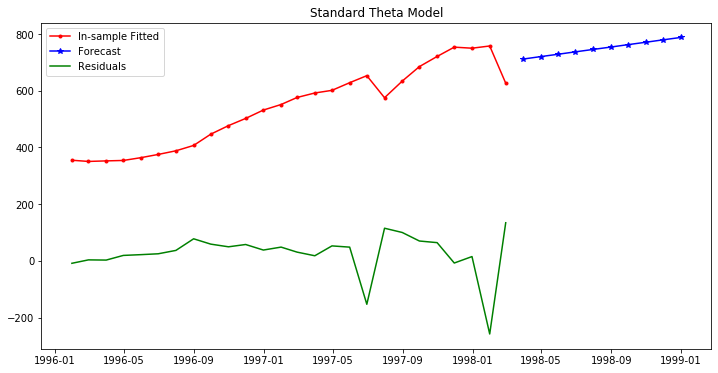

In [29]:
from theta_model import sesThetaF
val = [346.6565,  354.4733,  355.663 ,  373.6322,  386.2713,
  400.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  
  560.2689,  570.211, 600.12, 607.23, 610.23, 
  654.27, 676.89, 500.24, 690.56, 734.23, 
  755.23, 785.23, 746.217, 765.23, 500.23, 761.25] 

index= pd.date_range(start='01-01-1996', end='02-28-1998', freq='M')
data = pd.Series(val, index)
print(type(data))
model = sesThetaF(data, s_period = 10)

mean = model['mean']

fitted =  model['fitted']

residuals = model['residuals']

plt.figure(figsize = (12,6))

plt.plot(fitted, marker = '.', color = 'red', label = 'In-sample Fitted')
plt.plot(mean, marker = '*', color = 'blue', label = 'Forecast')
plt.plot(residuals, marker = '', color = 'green', label = 'Residuals')
plt.title('Standard Theta Model')
plt.legend()
plt.show()

In [187]:
from sklearn.metrics import mean_squared_error
for _, device in grp:
    device = device.reset_index(level = ["store_id", "device_id"], drop=True)["num_orders"].asfreq("D")
    print(type(device.asfreq("D")))
    model = sesThetaF(device, 11)
    # train = device.iloc[:-7]
    # test = device.iloc[-7:]
    # pred = theta(train, 7).set_index(test.index)
    # plt.plot(device["num_orders"].reset_index(level = ["store_id", "device_id"], drop=True))
    # plt.plot(pred["num_orders"].reset_index(level = ["store_id", "device_id"], drop=True))
    # plt.show()
    # plt.plot(device["product_256"].reset_index(level = ["store_id", "device_id"], drop=True))
    # plt.plot(pred["product_256"])
    # plt.show()
    
    # print(mean_squared_error(test, pred, squared=False, multioutput="uniform_average"))
    break

<class 'pandas.core.series.Series'>


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [123]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD

def forecast_test(df, intervals, freqs, f_methods, c_methods, verbose=False):
    start_time = time.time()
    scores = []
    windows = [(train, test, get_test_train_split(df, train, test)[-1]) for train, test in intervals]
    n_tests = len(windows)*len(freqs)*len(f_methods)
    tests_completed = 0

    for train_l, test_l, (start, mid, end) in windows:
        if train_l <= test_l:
            tests_completed += len(freqs)
            if verbose:
                time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")
            continue

        window = df[(df.index.get_level_values("date") > start) & (df.index.get_level_values("date") <= end)]
        for freq in freqs:
            window_f = format_ts(window, start, end, freq, normalize=True)
            rmse = []
            r2 = []
            clust_ami = {c_m.__name__ : [] for c_m in c_methods}

            true_val = window_f[window_f.index.get_level_values("date") > mid]
            true_val = format_ts(true_val, mid, end, freq, flatten=True, normalize=True)
            true_svd = TruncatedSVD(n_components=min(1000, true_val.shape[1]-1), random_state=0)
            true_svd.fit(true_val)
            true_variance = true_svd.explained_variance_ratio_.cumsum()
            true_clust = {c_method.__name__ : c_method(true_svd.transform(true_val)[:,true_variance < 0.96], 4) for c_method in c_methods}

            for f_method in f_methods:
                pred_val = pd.DataFrame(index=pd.MultiIndex.from_arrays([[]] * 3, names=['store_id', 'device_id', 'date']), columns=window_f.columns)
                for _, device in window_f.groupby(level="device_id"):
                    train = device[(device.index.get_level_values("date") <= mid)]
                    test = device[(device.index.get_level_values("date") > mid)]
                    pred = f_method(train, len(test)).set_index(test.index)
                    pred_val = pred_val.append(pred, verify_integrity=True)
                    
                    rmse.append(mean_squared_error(test, pred, squared=False, multioutput="uniform_average"))
                    r2.append(r2_score(test, pred, multioutput="variance_weighted"))

                res = {
                    "train_window": train_l, 
                    "test_window": test_l, 
                    "freq": freq, 
                    "forecast_method": f_method.__name__, 
                    "rmse": np.mean(rmse), 
                    "r2_score": np.mean(r2)
                    }

                pred_val = pred_val.astype(float)
                pred_val = format_ts(pred_val, mid, end, freq, flatten=True, normalize=True)
                pred_svd = TruncatedSVD(n_components=min(1000, pred_val.shape[1]-1), random_state=0)
                pred_svd.fit(pred_val)
                pred_variance = pred_svd.explained_variance_ratio_.cumsum()
                pred_val = pred_svd.transform(pred_val)[:,pred_variance < 0.96]

                for c_method in c_methods:
                    res["ami_"+c_method.__name__] = adjusted_mutual_info_score(true_clust[c_method.__name__], c_method(pred_val, 4))
                scores.append(res)

                tests_completed += 1
                if verbose:
                    time_est = (n_tests-tests_completed) * (datetime.timedelta(seconds=(time.time()-start_time)) / tests_completed)
                    print("\rTest:", str(tests_completed) + "/" + str(n_tests), "\tTime remaining (est):", str(time_est), end="")
        
    if verbose:
        print("\nDone! Total time:", str(datetime.timedelta(seconds=(time.time()-start_time))))
    return scores

In [124]:
TEST_NAME = "naive-var_train-2-W_test-1-14-D_freq-12-24-H"
TEST_RES_PATH = "./test_results/forecast/" + TEST_NAME + ".csv"

In [125]:
import itertools
INTERVALS = itertools.product([pd.Timedelta(n, unit="W") for n in [2]], [pd.Timedelta(n, unit="D") for n in [1]])#, 3, 7, 14]])
FREQ_UNIT = "H"
FREQS = [str(n)+FREQ_UNIT for n in [24]]
F_METHODS = [var]
C_METHODS = [k_means, agglomerative_single]

TEST_DF = pd.DataFrame(forecast_test(TSF, INTERVALS, FREQS, F_METHODS, C_METHODS, verbose=True))

Test: 1/1 	Time remaining (est): 0:00:00
Done! Total time: 0:03:50.476063


In [126]:
TEST_DF.set_index(["train_window", "test_window", "freq", "forecast_method"], inplace=True)
TEST_DF

,,,,rmse,r2_score,ami_k_means,ami_agglomerative_single
train_window,test_window,freq,forecast_method,,,,
14 days,1 days,24H,var,0.067701,NaN,0.31958,0.330947


In [340]:
TEST_DF

rmse  r2_score  ami_k_means  ami_agglomerative_single
train_window test_window freq forecast_method                                                           
14 days      1 days      12H  naive_forecast   0.064948 -1.202241     0.309701                  0.330947
                         24H  naive_forecast   0.080606       NaN     0.296801                  0.330947
             3 days      12H  naive_forecast   0.084730 -1.795501     0.250077                  0.330947
                         24H  naive_forecast   0.107113 -2.564714     0.256404                  0.330947
             7 days      12H  naive_forecast   0.075870 -0.702577     0.354666                  0.330950
                         24H  naive_forecast   0.094754 -0.933284     0.370872                  0.665450

In [329]:
save_df(TEST_DF, TEST_RES_PATH)

## SARIMAX

In [62]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [79]:
start, end = get_intervals(TSF, pd.Timedelta(8, unit="W"))[0]

window = TSF[(TSF.index.get_level_values("date") > start) & (TSF.index.get_level_values("date") <= end)]
formatted_window = format_ts(window, start, end, "24H", [], flatten=False, normalize=False)
grp = formatted_window.groupby(level="device_id")


In [303]:
for _, device in grp: 
    print(device.shape)
    y = device["product_256"].reset_index(level = ["store_id", "device_id"], drop=True)
    break

(50, 197)


In [304]:
sarimax(y, 10)

AttributeError: 'Series' object has no attribute 'columns'

In [306]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [307]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [308]:
min_aic = ((),(),np.inf)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y,
        order=param,
        seasonal_order=param_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < min_aic[2]:
            min_aic = (param, param_seasonal, results.aic)
        #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
print()
print("Best params:")
print('ARIMA{}x{} - AIC:{}'.format(*min_aic))


Best params:
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:201.7268851161482


In [309]:
mod = sm.tsa.statespace.SARIMAX(y,
    order=(0, 0, 1),
    seasonal_order=(0, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3013      0.193     -1.563      0.118      -0.679       0.077
ma.S.L7       -0.6333      0.219     -2.894      0.004      -1.062      -0.204
sigma2        17.8599      3.447      5.182      0.000      11.105      24.615


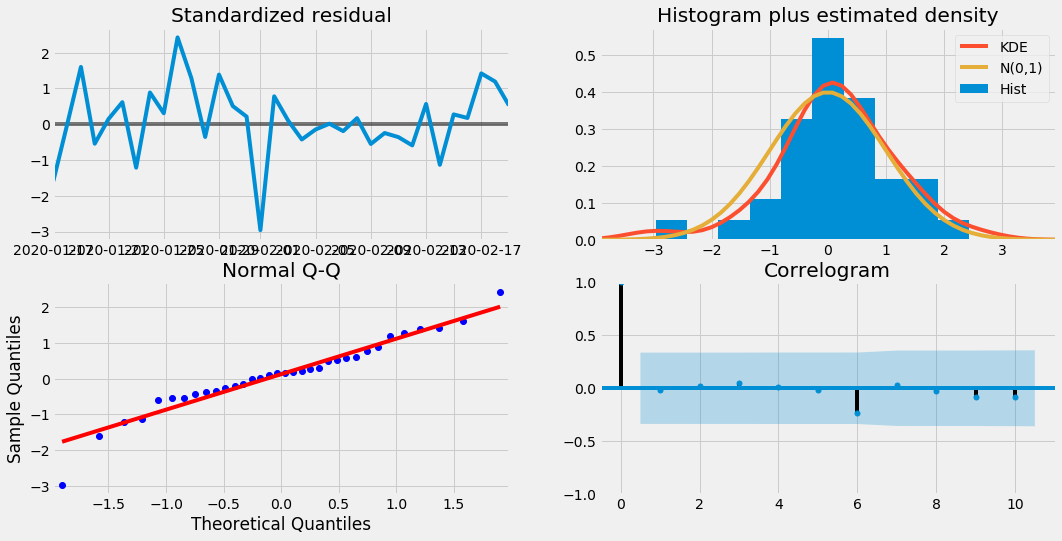

In [310]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

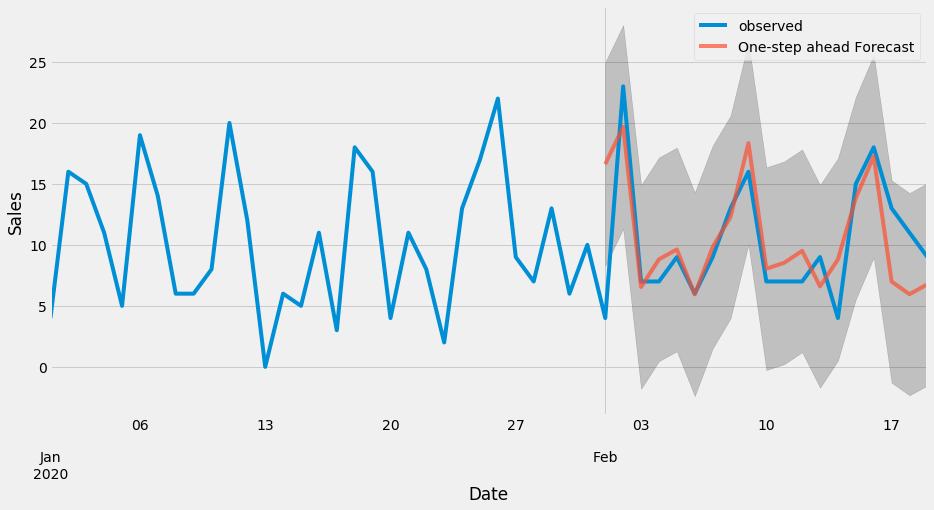

In [311]:
pred = results.get_prediction(start=pd.to_datetime('2020-02-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

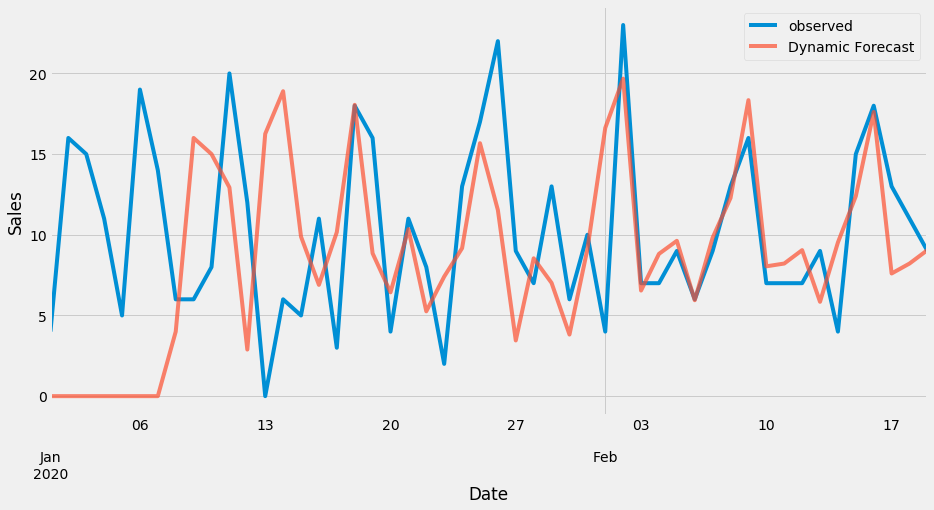

In [317]:
pred = results.get_prediction(start="2020-01-01", dynamic='2020-02-10')
#pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 7))
#ax.fill_between(pred_ci.index,
                #pred_ci.iloc[:, 0],
                #pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [277]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 54.62
The Root Mean Squared Error of our forecasts is 7.39


# Extras

In [256]:
def get_top_cols(df, row_index, n_cols):
    if len(df) == 0:
        return []
    row_frame = df.iloc[row_index].copy()
    columns = []
    for _ in range(n_cols):
        if len(row_frame) == 0:
            break
        col_id = row_frame.idxmax()
        columns.append(col_id)
        row_frame = row_frame.drop([col_id])
    return columns

In [257]:
def get_color_dict(labels):
    #labels = [col for col in df.columns if col not in ["device_id", "date", "store_id", "class", "total_price"]]
    colors = [cm.rainbow(i) for i in np.linspace(0, 1, len(labels))]
    c_dict = {}
    for i, label in enumerate(labels):
        c_dict[label] = colors[i]
    return c_dict

In [ ]:
START_INDEX = 0
N_COLS = 6
COL_SET = set()
for D in DEVICES:
    DEVICE_FRAME = TSF.loc[TSF["device_id"] == D[0], COL_WL].copy()
    DEVICE_FRAME = DEVICE_FRAME.drop(["total_price"], axis=1)
    DEVICE_FRAME = DEVICE_FRAME.resample("H").sum().iloc[START_INDEX:]
    DEVICE_FRAME = DEVICE_FRAME.cumsum()
    for C in get_top_cols(DEVICE_FRAME, -1, N_COLS):
        COL_SET.add(C)
COLOR_DICT = get_color_dict(COL_SET)

In [ ]:
for D in DEVICES:
    DEVICE_FRAME = TSF.loc[TSF["device_id"] == D[0], column_whitelist].copy()
    if len(DEVICE_FRAME) == 0:
        continue
    DEVICE_FRAME = DEVICE_FRAME.drop(["total_price"], axis=1)
    DEVICE_FRAME = DEVICE_FRAME.resample("H").sum().iloc[START_INDEX:]
    DEVICE_FRAME = DEVICE_FRAME.cumsum()
    COLS = get_top_cols(DEVICE_FRAME, -1, N_COLS)
    fig = plt.figure()
    DEVICE_FRAME.plot(kind='line',y=COLS, figsize=(16, 10), color=[COLOR_DICT.get(x, '#666666') for x in COLS], linewidth=3.0)
    plt.legend(prop={'size': 18})
    plt.figtext(.5,.9, "Device "+str(D[0])+", Store "+str(D[2]),fontsize=24)
    #plt.show()
    plt.savefig("C:/Users/user/Desktop/store_/"+str(D[2]+"/"+"device_"+str(D[0])+"_day.png")
    plt.close(fig)

In [ ]:
def add_time_cols(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["day_of_month"] = df.index.day
    df["month"] = df.index.month
    holidays_swe = holidays.Sweden(include_sundays=False)[df.index[0]: df.index[-1]]
    df["holiday"] = [1 if d in holidays_swe else 0 for d in df.index.date]

def remove_zero_sequence(df, col, min_length):
    mask = col.groupby((col != col.shift()).cumsum()).transform('count').lt(min_length)
    mask = ~(mask | col.gt(0))
    df.drop(mask[mask].index, axis=0, inplace=True)

In [ ]:
def get_test_train_split(df, train_len=pd.Timedelta(4, unit='W'), forecast_len=pd.Timedelta(1, unit='W'), expanding_window=False):
    start = df.index.values[0]
    split = start + train_len
    forecast_end = split + forecast_len
    end = df.index.values[-1]
    sets = []
    while end > forecast_end:
        sets.append((df[start:split].index, df[split:forecast_end].index))
        if not expanding_window:
            start += train_len + forecast_len
        split += train_len + forecast_len
        forecast_end += train_len + forecast_len
    return sets

DEVICE_FRAME = TSF.loc[TSF["device_id"] == DEVICES[0][0], COL_WL].copy()
len(get_test_train_split(DEVICE_FRAME))

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

def train_and_predict_var(train_set, n_steps):
    model = VAR(endog=train_set)
    model_fit = model.fit(maxlags=2, trend="nc")
    print(model_fit.y)
    return
    prediction = model_fit.forecast(model_fit.y, steps=n_steps)
    return prediction

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def validate(predictions, true_val):
    sum_meanAE = mean_absolute_error(predictions, true_val).sum()
    sum_medianAE = median_absolute_error(predictions, true_val).sum()
    return sum_meanAE, sum_medianAE

In [ ]:
DEVICE_FRAME = TSF.loc[TSF["device_id"] == DEVICES[0][0], COL_WL].copy()
#DEVICE_FRAME["orders"] = 1
AGG_DICT = {col_name:np.sum for col_name in DEVICE_FRAME.columns}
AGG_DICT.update({"total_price":np.mean})
DEVICE_FRAME = DEVICE_FRAME.resample("H").agg(AGG_DICT).fillna(0).cumsum()
DEVICE_FRAME.rename(columns={'total_price': 'average_price'}, inplace=True)
DEVICE_FRAME.drop(["average_price"], axis=1, inplace=True)
#remove_zero_sequence(DEVICE_FRAME, DEVICE_FRAME.orders, 25)
#add_time_cols(DEVICE_FRAME)

In [ ]:
test_train = get_test_train_split(DEVICE_FRAME)
pred = train_and_predict_var(DEVICE_FRAME.loc[test_train[0][0]], len(test_train[0][1]))
validate(pred, DEVICE_FRAME.loc[test_train[0][1]])

In [ ]:
SUM_TRUE = DEVICE_FRAME.loc[test_train[0][1]]#DEVICE_FRAME.loc[test_train[0][0]].append(DEVICE_FRAME.loc[test_train[0][1]])
PRED = pd.DataFrame(index=SUM_TRUE.index,columns=SUM_TRUE.columns)
for j in range(0,len(DEVICE_FRAME.loc[test_train[0][1]].columns)):
    for i in range(0, len(pred)):
       PRED.iloc[i][j] = pred[i][j]
SUM_VAR = PRED
COLS = get_top_cols(SUM_TRUE, -1, 5)
COLOR_DICT = get_color_dict(COLS)
_, ax = plt.subplots()
SUM_TRUE.plot(ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
SUM_VAR.plot(linestyle='dashed', ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
plt.legend(prop={'size': 18})
plt.show()

In [ ]:
for train, test in get_test_train_split(DEVICE_FRAME, pd.Timedelta(4, unit='W'), pd.Timedelta(1, unit='W')):
    train = DEVICE_FRAME.loc[train]
    test = DEVICE_FRAME.loc[test]#-train.iloc[-1]
    pred = train_and_predict_var(train, len(test))
    #validate(pred, test)

    SUM_TRUE = test#DEVICE_FRAME.loc[test_train[0][0]].append(DEVICE_FRAME.loc[test_train[0][1]])
    PRED = pd.DataFrame(index=test.index,columns=test.columns)
    for j in range(0,len(test.columns)):
        for i in range(0, len(pred)):
            PRED.iloc[i][j] = pred[i][j]
    SUM_VAR = PRED#-train.iloc[-1]
    COLS = get_top_cols(SUM_TRUE, -1, 5)
    COLOR_DICT = get_color_dict(COLS)
    _, ax = plt.subplots()
    train.append(SUM_TRUE).plot(ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
    SUM_VAR.plot(linestyle='dashed', ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
    plt.legend(prop={'size': 18})
    plt.show()

In [ ]:
plt.scatter(DEVICE_FRAME.index, DEVICE_FRAME["orders"].cumsum())
plt.figure(figsize=(20,100))

In [ ]:
TRAIN_PERCENT = 0.8
TRAIN_SIZE = -336#int(len(DEVICE_FRAME)*TRAIN_PERCENT)
TRAIN_Y = DEVICE_FRAME[:TRAIN_SIZE]
TRAIN_Y = TRAIN_Y.loc[:, (TRAIN_Y != TRAIN_Y.iloc[0]).any()]
VAL_Y = DEVICE_FRAME[TRAIN_Y.columns][TRAIN_SIZE:]
#TRAIN_X = DEVICE_FRAME["day"]
#VAL_X = DEVICE_FRAME["day"]

In [ ]:
#creating the train and validation set
train = TRAIN_Y
valid = VAL_Y
naive_pred = DEVICE_FRAME[TRAIN_SIZE-1:-1]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [ ]:
#converting predictions to dataframe
pred = pd.DataFrame(index=valid.index,columns=VAL_Y.columns)
for j in range(0,len(VAL_Y.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [ ]:
#check rmse
print("MAE VAR, MAE Naive, Min Val, Max Val")
MIN = valid.min()
MAX = valid.max()
SUM_MAE = 0
for i in pred.columns:
    SUM_MAE += mean_absolute_error(pred[i], valid[i])
    print('MAE value for', str(i)+':\t', mean_absolute_error(pred[i], valid[i]), "\t", mean_absolute_error(naive_pred[i], valid[i]), "\t", MIN[i], "\t", MAX[i])
print("AVG MAE:", (SUM_MAE/len(VAL_Y.columns)))

In [ ]:
#converting predictions to dataframe
pred = pd.DataFrame(index=valid.index,columns=DEVICE_FRAME.columns)
for j in range(0,len(DEVICE_FRAME.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
print("RMSE for VAR predictions and Naive Predictions")
for i in DEVICE_FRAME.columns:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])), "\t", sqrt(mean_squared_error(naive_pred[i], valid[i])))

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

DEVICE_FRAME = sc.fit_transform(DEVICE_FRAME)
DEVICE_FRAME.min()